In [1]:
%config Completer.use_jedi=False
%matplotlib inline

In [2]:
from datasets import load_dataset
from labels import mapping

import pandas as pd
pd.set_option("display.max_colwidth", -1)
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

2022-05-01 21:10:28.671589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 21:10:28.673611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/tmp/ipykernel_8188/982806629.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


Load the dataset and split it into train, valid, and test

In [3]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/home/calixto/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

Convert the dataset to a one-hot representation

In [4]:
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels

In [5]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [6]:
train_oh_labels.shape

(43410, 28)

In [7]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

Quick check of the data

In [8]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [9]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'distribution of labels in test'}>

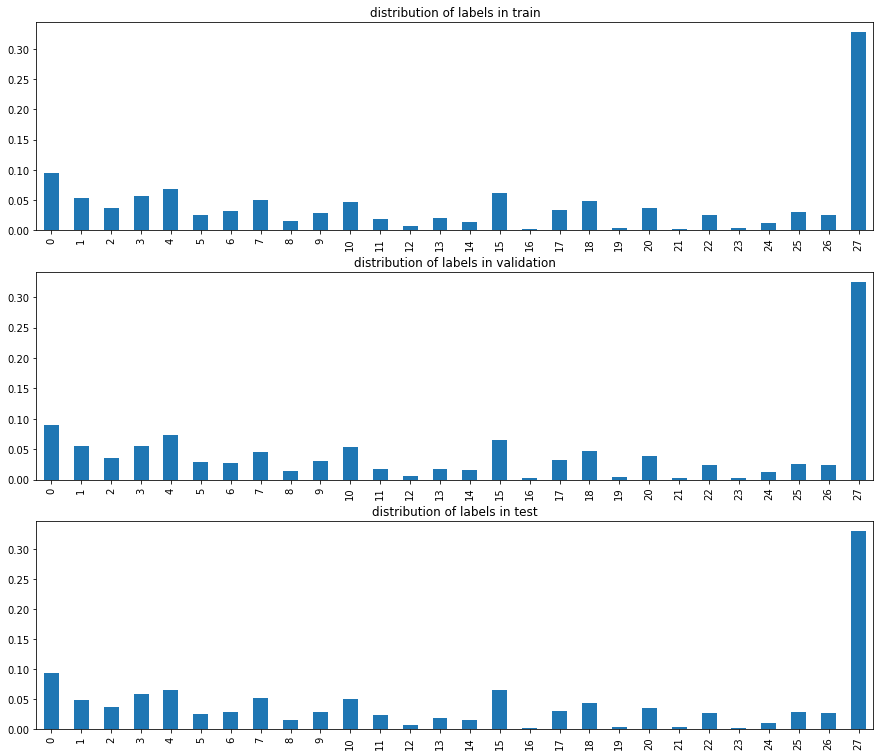

In [10]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [11]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}\n")
    for text in samples["text"]:
        print(text + "\n---")

In [12]:
inspect_data(5)

examples from caring

R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
---
Even while [NAME] in a America are discriminated against, they still have such warm hearts. [NAME] Bless them (my [NAME], and theirs)
---
If you’re concerned about [NAME], then you must still be concerned about [NAME]. WAR over last 2 seasons: [NAME]: 4.8, 3.1 [NAME]: 4.0, 3.6
---
> it’s a low f-ing bar lbr It is indeed. But I am glad that you found a man who doesn't want anal.
---
Well if you're moving to Dallas, it's basically the same thing as Oklahoma and California combined. You're totally safe there!
---


Define a Pytorch dataset

In [13]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]
        
        inputs = self.tokenizer.encode_plus(text, 
                                            None, 
                                            add_special_tokens=True, 
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

define a tez model

In [14]:
class config:
    def __init__(self):
        self.val_strategy = "batch"

class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.config = config()
        
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            }
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt
    
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())
    
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}
    
    def forward(self, ids, mask, targets= None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

Star the training

In [15]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

In [ ]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="export/model.bin")

model.fit(train_dataset, 
          valid_dataset, 
          train_bs=64, 
          device="cpu", 
          epochs=8, 
          callbacks=[tb_logger, es], 
          fp16=True, 
          n_jobs=10)

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/calixto/Documentos/botcryptowatcher/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: T

NOTE: This is old Model class and is deprecated. It will no longer be maintained! Please use version > 0.5.1. Its much better and supports multi-gpu training too!


100%|█████| 340/340 [04:30<00:00,  1.26it/s, auc=0.853, loss=0.129, stage=valid]
2022-05-01 23:34:32,097 INFO 
Score improved (inf --> 0.1286448286517578). Saving model!
 36%|█  | 246/679 [51:08<1:35:20, 13.21s/it, auc=0.862, loss=0.125, stage=train]